# Data Modeling with Logistic Regression model

Below is the logistic regression model for predicting arrest after a Terry Stop is taking place. The final regression model is based upon a third degree polynomial model of four features: `Officer Gender`, `Reported Time`, `weapon_present`, and `Initial Call Type`.

Below are the imports.

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

import pandas as pd
import numpy as np

from mlxtend.plotting import plot_decision_regions
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import KBinsDiscretizer, FunctionTransformer
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from category_encoders import WOEEncoder, TargetEncoder
from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.preprocessing import PolynomialFeatures as Poly

from mlxtend.evaluate import feature_importance_permutation

from mlxtend.feature_extraction import PrincipalComponentAnalysis
from mlxtend.preprocessing import standardize

from mlxtend.feature_extraction import RBFKernelPCA as KPCA
from pyearth import Earth

from mlxtend.plotting import plot_pca_correlation_graph

# from umap import UMAP

import warnings
warnings.filterwarnings("ignore")

The pipeline components to be used. The stringify is used for the scorecard of weighted evidence that we used as a baseline. This is currently not the best model. The polynomial regression model does better. Left in the code for possible future reference if needed.

In [10]:
def stringify(data):
    if type(data) != pd.core.frame.DataFrame:
        X = pd.DataFrame(data)
    else:
        X = data
        
    for c in X.columns.tolist():
        X[c] = X[c].astype(str)
#     X = X.applymap(str)
    return X

objectify = FunctionTransformer(func = stringify, check_inverse = False, validate=False)
binner = KBinsDiscretizer(n_bins = 10, encode = 'ordinal')
poly = Poly(degree=3)
encoder = WOEEncoder()
clf = LogisticRegression(class_weight='balanced')

Read the data to train the model and make predictions.

In [11]:
df = pd.read_csv('../data/Terry_Stops_added_features.csv')

In [12]:
df.columns

Index(['Subject Age Group', 'Subject ID', 'GO / SC Num', 'Terry Stop ID',
       'Stop Resolution', 'Weapon Type', 'Officer ID', 'Officer YOB',
       'Officer Gender', 'Officer Race', 'Subject Perceived Race',
       'Subject Perceived Gender', 'Reported Date', 'Reported Time',
       'Initial Call Type', 'Final Call Type', 'Call Type', 'Officer Squad',
       'Arrest Flag', 'Frisk Flag', 'Precinct', 'Sector', 'Beat',
       'subject_age_groups', 'stop_resolution', 'arrest_flag',
       'weapon_present', 'officer_gender', 'officer_race', 'subject_race',
       'subject_gender'],
      dtype='object')

Set the target field.

In [13]:
target = 'arrest_flag'

Run the polynomial logistic regression moxdel. The performance of the model is determined using cross validation and uses area unbder the curve (AUC) as its metric.

In [14]:
# excluded_cols = ['arrest_flag', 'Arrest Flag', 'stop_resolution', 'Stop Resolution', 'Subject ID']

# used_cols = [c for c in df.columns if (c not in [target, 'stop_resolution'] and '_' in c)]
# used_cols = [c for c in df.columns if c not in excluded_cols]

used_cols = ['Officer Gender', 'Reported Time', 'weapon_present', 'Initial Call Type']
X = df[used_cols]
y = df[target]

scorecard = make_pipeline(objectify, encoder, poly, clf)

scores = cross_val_score(scorecard, X.values, y.values, cv=5, scoring='roc_auc')
print(scores.mean(), "+/-", scores.std())

0.8597557865754016 +/- 0.007328641075193442


Comparing the cross validated scores of the different logistic fregression models:

* scorecard, no poly = 0.7316332047925206 +/- 0.016245739477284915
* 2 degrees = 0.8392500438013089 +/- 0.019636147953002545
* 3 degrees = 0.8597557865754016 +/- 0.007328641075193442
* 4 degrees = 0.8726112180444696 +/- 0.01681182446652548

The third degree polynomial model seems to be best (has lowest standard deviation), and is hence the most stable of the models. The third degree polynomial model is using 35 features overall as can be seen below. It is unclear what the various features are, and to determine that we will develop a decision tree to figure out which interactions are the most important.

In [14]:
pd.DataFrame(Pipeline(scorecard.steps[:-1]).fit_transform(X.values, y.values))

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,1.0,-0.021253,0.231792,-0.038832,-2.229887,0.000452,-0.004926,0.000825,0.047392,0.053728,...,0.012454,-0.002086,-0.119807,0.000350,0.020071,1.152564,-0.000059,-0.003362,-0.193086,-11.087886
1,1.0,-0.021253,0.432463,-0.038832,-2.229887,0.000452,-0.009191,0.000825,0.047392,0.187024,...,0.080881,-0.007262,-0.417043,0.000652,0.037447,2.150379,-0.000059,-0.003362,-0.193086,-11.087886
2,1.0,-0.021253,-0.260684,-0.038832,-2.229887,0.000452,0.005540,0.000825,0.047392,0.067956,...,-0.017715,-0.002639,-0.151535,-0.000393,-0.022573,-1.296225,-0.000059,-0.003362,-0.193086,-11.087886
3,1.0,-0.021253,-0.340727,-0.038832,-2.229887,0.000452,0.007242,0.000825,0.047392,0.116095,...,-0.039557,-0.004508,-0.258878,-0.000514,-0.029504,-1.694229,-0.000059,-0.003362,-0.193086,-11.087886
4,1.0,-0.021253,-0.203526,-0.038832,-2.229887,0.000452,0.004326,0.000825,0.047392,0.041423,...,-0.008431,-0.001609,-0.092368,-0.000307,-0.017623,-1.012010,-0.000059,-0.003362,-0.193086,-11.087886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39392,1.0,-0.021253,0.000000,-0.038832,0.085189,0.000452,-0.000000,0.000825,-0.001811,0.000000,...,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000059,0.000128,-0.000282,0.000618
39393,1.0,-0.021253,0.000000,-0.038832,0.553724,0.000452,-0.000000,0.000825,-0.011768,0.000000,...,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000059,0.000835,-0.011906,0.169778
39394,1.0,-0.021253,0.000000,-0.038832,-2.229887,0.000452,-0.000000,0.000825,0.047392,0.000000,...,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000059,-0.003362,-0.193086,-11.087886
39395,1.0,-0.021253,2.224223,-0.038832,0.842052,0.000452,-0.047272,0.000825,-0.017896,4.947166,...,11.003599,-0.192106,4.165771,0.003354,-0.072728,1.577089,-0.000059,0.001270,-0.027534,0.597058


Map the index to the column numbers. Note this is **without** the interaction terms!

In [15]:
for i, col in enumerate(used_cols):
    print(i, ":", col)

0 : Officer Gender
1 : Reported Time
2 : weapon_present
3 : Initial Call Type


The most important feature is `Reported Time`. Note that this is without considering the interactions. That the `Reported Time` is such an important featureis confirmed in the decision tree model (see tree notebook).

In [16]:
from mlxtend.evaluate import feature_importance_permutation
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, 
                                                    test_size=.20, random_state=42, 
                                                    stratify=y.values)

scorecard.fit(X_train, y_train)
imp_vals, _ = feature_importance_permutation(
    predict_method=scorecard.predict, 
    X=X_test,
    y=y_test,
    metric='accuracy',
    num_rounds=1,
    seed=1)

print(imp_vals)

[ 0.00050761  0.0142132   0.0001269  -0.00444162]


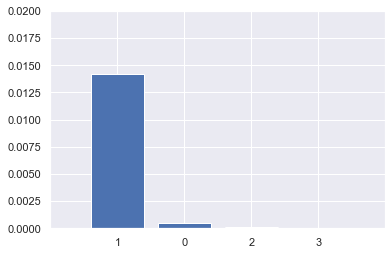

In [17]:
indices = np.argsort(imp_vals)[::-1]
plt.figure()
plt.bar(range(X.shape[1]), imp_vals[indices])
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.ylim([0, 0.02])
plt.show()